In [1]:
# =======================
# 1. Install dependencies
# =======================
!pip install -q kaggle pytorch-lightning efficientnet_pytorch opencv-python-headless

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 60.2 MB/s eta 0:00:0

In [2]:
# ================================
# 2. Upload your Kaggle API key
# ================================
from google.colab import files
files.upload()   # <-- Upload kaggle.json from your Kaggle account

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paritoshsharma25","key":"26209822faa8fa84b6fd879e093a0202"}'}

In [3]:
# ================================
# 3. Set up Kaggle & Download Data
# ================================
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download Plant Seedlings Classification dataset
!kaggle competitions download -c plant-seedlings-classification
!unzip -q plant-seedlings-classification.zip -d data/

 99% 1.67G/1.69G [00:13<00:00, 201MB/s]
100% 1.69G/1.69G [00:13<00:00, 137MB/s]


In [4]:
# =======================
# 1. Check Data Structure
# =======================
import os

data_path = 'data/train'
classes = sorted(os.listdir(data_path))
print(f"Found {len(classes)} plant species (classes):")
print(classes)

# Show number of images per class
for cls in classes:
    n_imgs = len(os.listdir(os.path.join(data_path, cls)))
    print(f"{cls}: {n_imgs} images")

Found 12 plant species (classes):
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


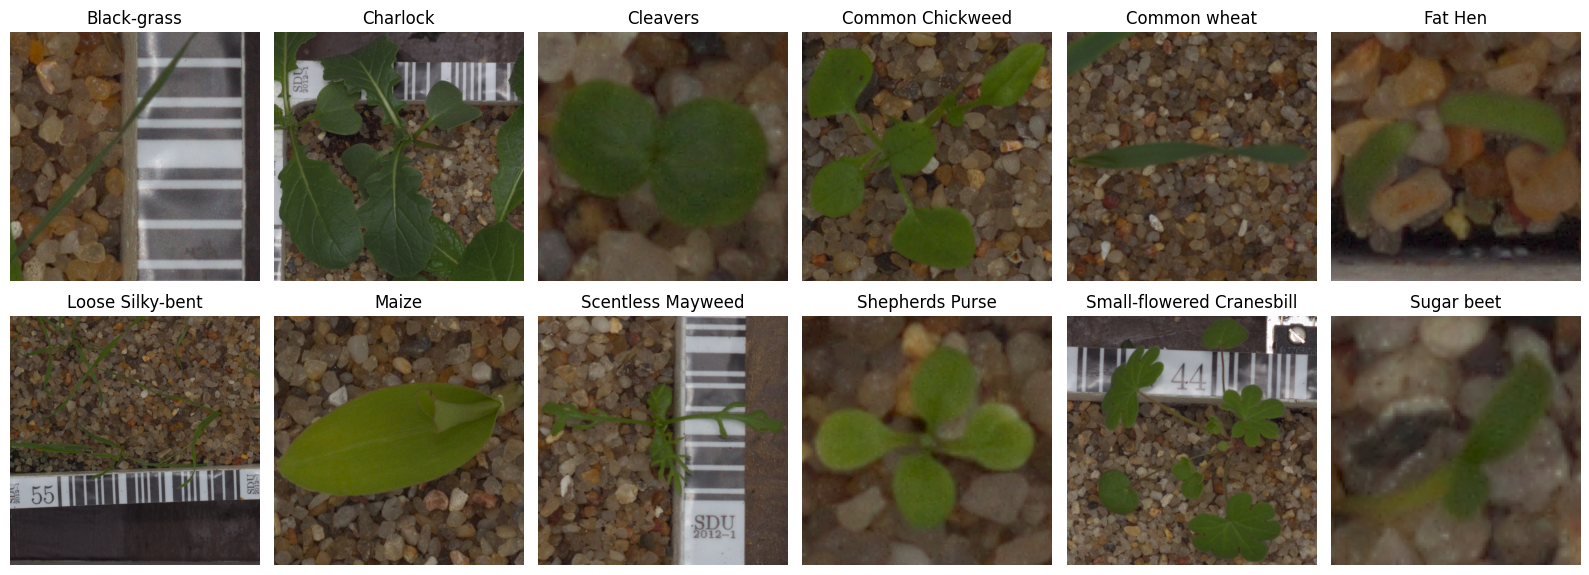

In [5]:
# =======================
# 2. Show Example Images
# =======================
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(2, 6, figsize=(16, 6))
for idx, cls in enumerate(classes[:12]):
    img_path = os.path.join(data_path, cls, os.listdir(os.path.join(data_path, cls))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[idx//6, idx%6].imshow(img)
    axs[idx//6, idx%6].set_title(cls)
    axs[idx//6, idx%6].axis('off')
plt.tight_layout()
plt.show()

In [6]:
import os
import shutil
import random
from tqdm import tqdm

# Set seed for reproducibility
random.seed(42)

original_data_dir = 'data/train'
split_base = 'data/split'
train_dir = os.path.join(split_base, 'train')
val_dir = os.path.join(split_base, 'val')

In [7]:
# Create split directories
for split_dir in [train_dir, val_dir]:
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# Split ratio (e.g., 85% train, 15% val)
split_ratio = 0.85

In [8]:
# For each class, shuffle and split images
for cls in tqdm(os.listdir(original_data_dir), desc="Splitting data by class"):
    cls_folder = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_folder)
    random.shuffle(images)
    n_train = int(len(images) * split_ratio)
    train_imgs = images[:n_train]
    val_imgs = images[n_train:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(val_dir, cls, img))

print("Splitting complete!")

Splitting data by class: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]

Splitting complete!


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl

# Mean/std calculated from ImageNet; fine for transfer learning
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class PlantSeedlingsDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=2, img_size=224):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

    def setup(self, stage=None):
        # Training transforms: augment
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
        # Validation: center crop only
        self.val_transforms = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "train"), self.train_transforms)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "val"), self.val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)


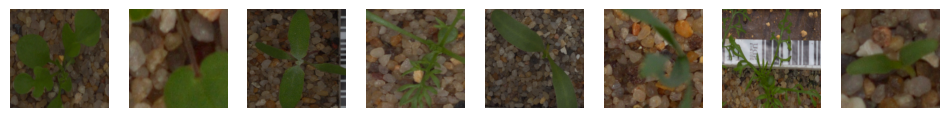

In [10]:
# Usage example:
data_module = PlantSeedlingsDataModule(data_dir='data/split', batch_size=32, num_workers=2)
data_module.setup()

batch = next(iter(data_module.train_dataloader()))
images, labels = batch
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
for i in range(8):
    img = images[i].permute(1,2,0).cpu().numpy() * IMAGENET_STD + IMAGENET_MEAN
    img = (img * 255).astype('uint8')
    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [29]:
# -------------------
# Imports & DataModule
# -------------------
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# Define DataModule
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir='data/split', batch_size=64, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'train'), transform=self.transform)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'val'), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [30]:
# ----------------------
# ViT Classifier Module
# ----------------------
from torchvision import models

class ViTClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = models.vit_b_16(pretrained=True)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs)
        return [optimizer], [scheduler]

In [31]:
# ----------------------------
# Init, Train, Load Best Model
# ----------------------------
data_module = DataModule()
data_module.setup()

num_classes = len(os.listdir('data/split/train'))
model = ViTClassifier(num_classes=num_classes)

checkpoint_cb = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='vit-best')
early_stop_cb = EarlyStopping(monitor='val_acc', mode='max', patience=10)
lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger("lightning_logs", name="vit")

trainer = pl.Trainer(
    max_epochs=12,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision=16,
    callbacks=[checkpoint_cb, early_stop_cb, lr_monitor],
    logger=logger
)

# Train
trainer.fit(model, datamodule=data_module)

# Log best model results
print(f"\n Best model path: {checkpoint_cb.best_model_path}")
print(f" Best validation accuracy: {checkpoint_cb.best_model_score.item():.4f}")


# Load best model checkpoint to get state dict
best_ckpt = torch.load(checkpoint_cb.best_model_path)
model.load_state_dict(best_ckpt['state_dict'])
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for batch in data_module.val_dataloader():
        images, targets = batch
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

best_val_loss = total_loss / total_samples
print(f" Best validation loss: {best_val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.



 Best model path: lightning_logs/vit/version_3/checkpoints/vit-best.ckpt
 Best validation accuracy: 0.9625
 Best validation loss: 0.1393


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize model architecture
best_model = ViTClassifier(num_classes=num_classes)

# Load the best checkpoint weights from your saved checkpoint file
checkpoint = torch.load(checkpoint_cb.best_model_path)
best_model.load_state_dict(checkpoint['state_dict'])

best_model = best_model.to(device)
best_model.eval()

ViTClassifier(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): L

In [42]:
# ----------------------------
# Validation Metrics & Confusion Matrix
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import torch.nn as nn

# Make sure model is in eval mode and on the right device
best_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

# Initialize lists and loss
all_preds = []
all_targets = []
total_loss = 0.0
total_samples = 0

criterion = nn.CrossEntropyLoss()

# Loop through validation set
with torch.no_grad():
    for images, targets in data_module.val_dataloader():
        images, targets = images.to(device), targets.to(device)
        outputs = best_model(images)
        loss = criterion(outputs, targets)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
avg_loss = total_loss / total_samples
accuracy = (all_preds == all_targets).mean()

# Print basic metrics
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Average Loss: {avg_loss:.4f}")


Validation Metrics:
Accuracy: 0.9625 (96.25%)
Average Loss: 0.1393


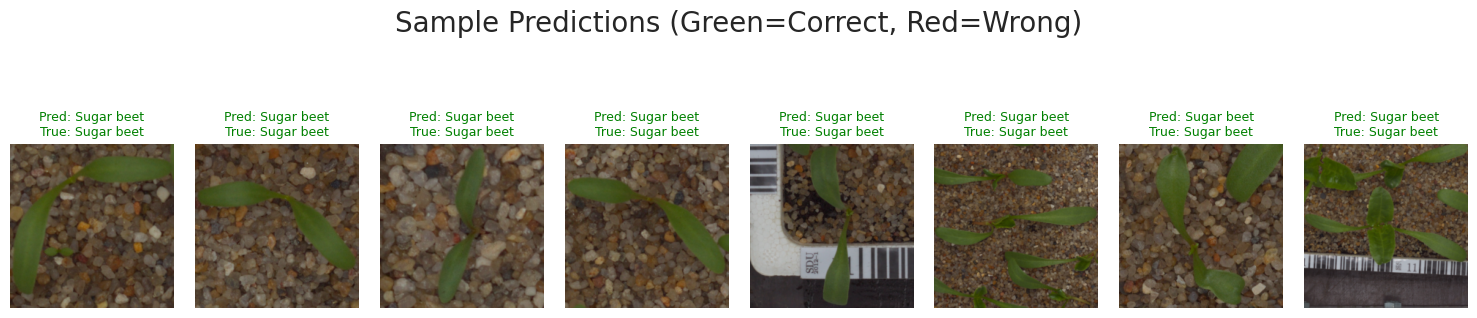

In [43]:
# Get predictions
outputs = best_model(images.to(device))
preds = outputs.argmax(1)

# Move images and targets back to CPU for visualization
images = images.cpu()
targets = targets.cpu()

plt.figure(figsize=(15, 4))
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
for i in range(min(8, len(images))):  # Ensure we don't exceed batch size
    img = images[i].permute(1, 2, 0) * IMAGENET_STD + IMAGENET_MEAN
    img = torch.clamp(img, 0, 1)

    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    color = 'green' if preds[i] == targets[i] else 'red'
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[targets[i]]}",
             fontsize=9, color=color)
    plt.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)')
plt.tight_layout()
plt.show()


In [44]:
# At the end, save results for ViT
torch.save({
    'model_name': 'ViT-B_16',
    'accuracy': accuracy,
    'loss': avg_loss,
    'best_model_path': checkpoint_cb.best_model_path
}, 'vit_b16_results.pt')


Comapring all the Results


In [48]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style and context for professional look
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 20,
    'figure.figsize': (12, 7)
})

In [49]:
result_files = [
    '/content/cnn_results.pt',
    '/content/resnet18_results.pt',
    '/content/densenet121_results.pt',
    '/content/efficientnet-b0_results.pt',
    '/content/vit_b16_results.pt'  # Your ViT results saved here
]


In [51]:
results = []
for file in result_files:
    data = torch.load(file, weights_only=False)  # Add weights_only=False here
    results.append({
        'Model': data.get('model_name', 'Unknown'),
        'Val Accuracy': data.get('accuracy', None),
        'Val Loss': data.get('loss', None),
        'Best Model Path': data.get('best_model_path', 'N/A')
    })
df_results = pd.DataFrame(results)
df_results

,Model,Val Accuracy,Val Loss,Best Model Path
0,CNN,0.794444,0.730703,/content/lightning_logs/version_0/checkpoints/...
1,ResNet18,0.901389,0.284937,/content/lightning_logs/version_2/checkpoints/...
2,DenseNet121,0.929167,0.217339,/content/lightning_logs/version_1/checkpoints/...
3,EfficientNet_B0,0.961111,0.124522,/content/lightning_logs/version_0/checkpoints/...
4,ViT-B_16,0.962500,0.139336,lightning_logs/vit/version_3/checkpoints/vit-b...


In [53]:
# Display the table with nice formatting
df_styled = df_results.style.background_gradient(cmap='YlGnBu').format({
    'Val Accuracy': '{:.4f}',
    'Val Loss': '{:.4f}'
})
df_styled

,Model,Val Accuracy,Val Loss,Best Model Path
0,CNN,0.7944,0.7307,/content/lightning_logs/version_0/checkpoints/cnn-best.ckpt
1,ResNet18,0.9014,0.2849,/content/lightning_logs/version_2/checkpoints/resnet18-best.ckpt
2,DenseNet121,0.9292,0.2173,/content/lightning_logs/version_1/checkpoints/densenet121-best.ckpt
3,EfficientNet_B0,0.9611,0.1245,/content/lightning_logs/version_0/checkpoints/efficientnet-b0-best.ckpt
4,ViT-B_16,0.9625,0.1393,lightning_logs/vit/version_3/checkpoints/vit-best.ckpt


<ipython-input-54-1964943910>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


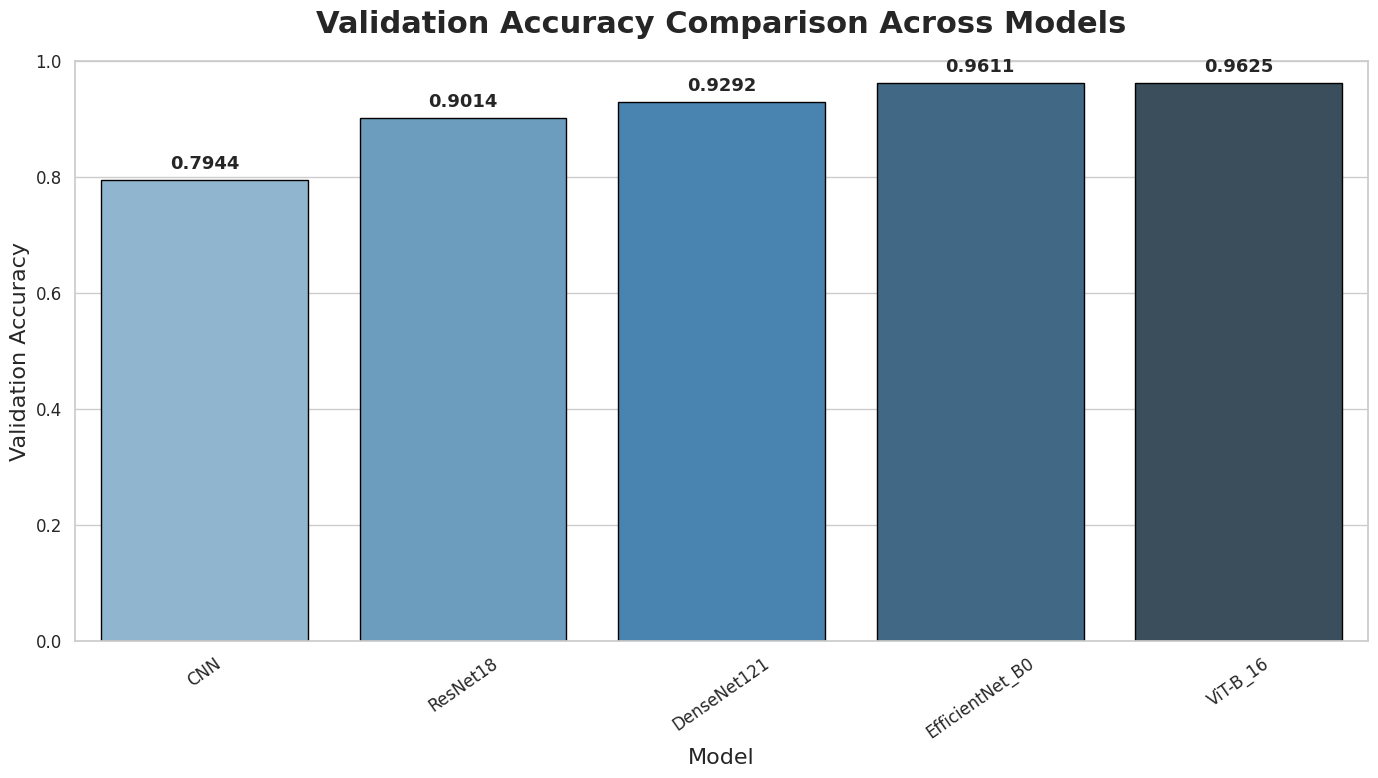

In [54]:
plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    x='Model', y='Val Accuracy', data=df_results, palette='Blues_d', edgecolor='black'
)

plt.title('Validation Accuracy Comparison Across Models', fontsize=22, weight='bold', pad=20)
plt.ylim(0, 1)
plt.ylabel('Validation Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=35)

# Add annotation on top of each bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(
        f'{height:.4f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=13, fontweight='bold',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

<ipython-input-55-3581573174>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


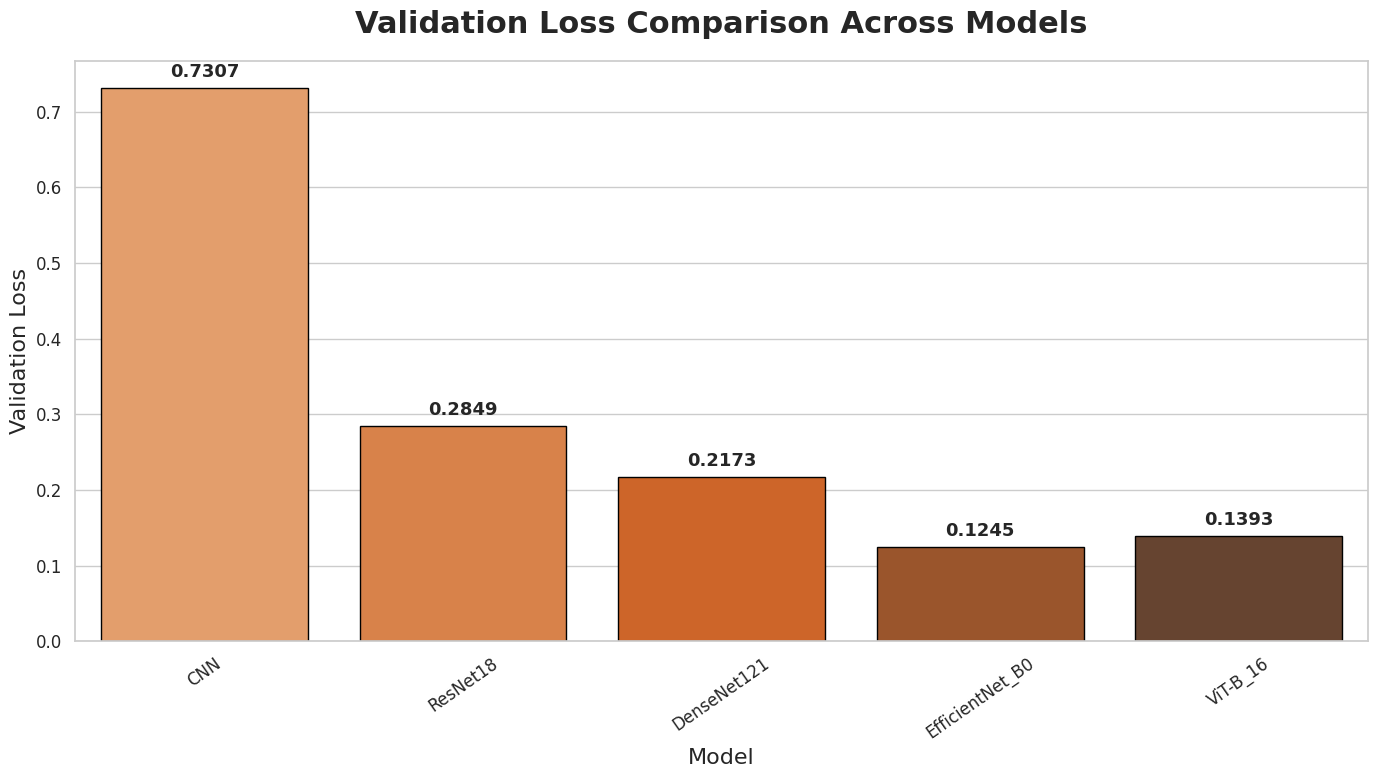

In [55]:
plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    x='Model', y='Val Loss', data=df_results, palette='Oranges_d', edgecolor='black'
)

plt.title('Validation Loss Comparison Across Models', fontsize=22, weight='bold', pad=20)
plt.ylabel('Validation Loss', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=35)

# Add annotation on top of each bar (loss values)
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(
        f'{height:.4f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=13, fontweight='bold',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

In [56]:
# Save accuracy plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Val Accuracy', data=df_results, palette='Blues_d', edgecolor='black')
plt.title('Validation Accuracy Comparison Across Models', fontsize=22, weight='bold', pad=20)
plt.ylim(0, 1)
plt.ylabel('Validation Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig('val_accuracy_comparison.png', dpi=300)
plt.close()

# Save loss plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Val Loss', data=df_results, palette='Oranges_d', edgecolor='black')
plt.title('Validation Loss Comparison Across Models', fontsize=22, weight='bold', pad=20)
plt.ylabel('Validation Loss', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig('val_loss_comparison.png', dpi=300)
plt.close()

<ipython-input-56-2980089598>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Val Accuracy', data=df_results, palette='Blues_d', edgecolor='black')
<ipython-input-56-2980089598>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Val Loss', data=df_results, palette='Oranges_d', edgecolor='black')
